In [1]:
import numpy as np
import raster_geometry as rg

import matplotlib.pyplot as plt

import torch
from torchmetrics.segmentation import DiceScore, HausdorffDistance, MeanIoU
from torchmetrics.functional.segmentation import dice_score, hausdorff_distance

In [4]:
target_class1 = rg.circle(shape=(128,128), radius=17, position=(0.7,0.2)).astype(int).reshape(1,1,128,128)
target_class2 = rg.circle(shape=(128,128), radius=19, position=(0.2,0.7)).astype(int).reshape(1,1,128,128)
target_class0 = (np.ones((1,1,128,128)) - np.logical_or(target_class1, target_class2)).astype(int)
target = np.concatenate([target_class0, target_class1, target_class2], axis=1)

preds_class1 = rg.circle(shape=(128,128), radius=21, position=(0.68,0.25)).astype(int).reshape(1,1,128,128)
preds_class2 = rg.circle(shape=(128,128), radius=17, position=(0.25,0.65)).astype(int).reshape(1,1,128,128)
preds_class0 = (np.ones((1,1,128,128)) - np.logical_or(preds_class1, preds_class2)).astype(int)
preds = np.concatenate([preds_class0, preds_class1, preds_class2], axis=1)

In [5]:
target.shape, preds.shape # batch[1], classes[3], height[128], width[128]

((1, 3, 128, 128), (1, 3, 128, 128))

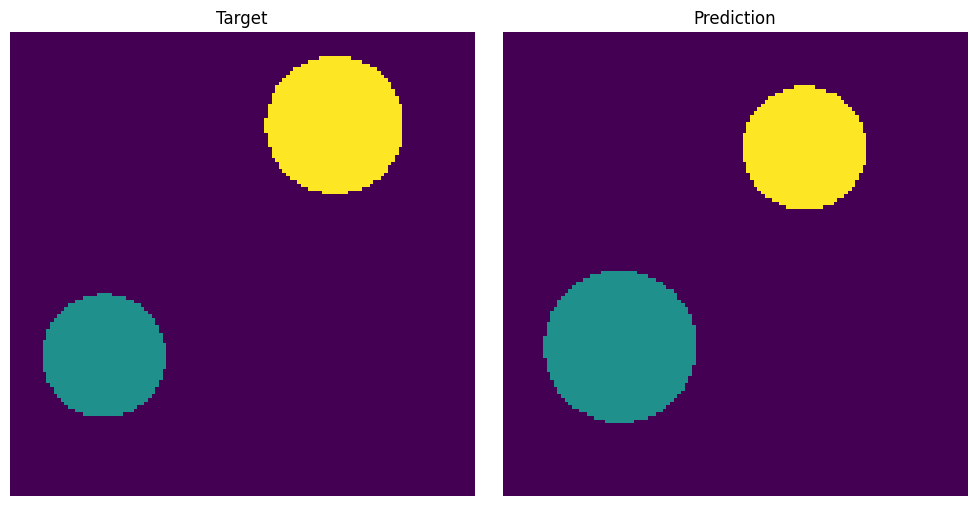

In [6]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(np.argmax(target[0], axis=0))
axes[0].axis('off')
axes[0].set_title('Target')

axes[1].imshow(np.argmax(preds[0], axis=0))
axes[1].axis('off')
axes[1].set_title('Prediction')

plt.tight_layout()
plt.show()

In [7]:
preds_torch = torch.from_numpy(np.concatenate([preds, preds, preds, preds], axis=0))            # batch:4 (repeat the same prediction)
target_torch = torch.from_numpy(np.concatenate([target, target, target, target], axis=0))       # batch:4 (repeat the same target)
preds_torch.shape, target_torch.shape

(torch.Size([4, 3, 128, 128]), torch.Size([4, 3, 128, 128]))

### Dice Score

https://lightning.ai/docs/torchmetrics/stable/segmentation/dice.html

Module Interface (https://lightning.ai/docs/torchmetrics/stable/segmentation/dice.html#module-interface)

In [45]:
dice_score_metric = DiceScore(num_classes=3, include_background=False, 
                              average='none', input_format='one-hot')

In [46]:
dice_score_metric(preds_torch, target_torch)

tensor([0.7334, 0.6790])

Functional Interface (https://lightning.ai/docs/torchmetrics/stable/segmentation/dice.html#functional-interface)

In [47]:
dice_score(preds_torch, target_torch, num_classes=3, include_background=False, 
           average='none', input_format='one-hot')

tensor([[0.7334, 0.6790],
        [0.7334, 0.6790],
        [0.7334, 0.6790],
        [0.7334, 0.6790]])

In [48]:
# average='none' -> Calculate the metric for each class separately, 
# and return the metric for every class.
dice_score(preds_torch, target_torch, num_classes=3, include_background=False, 
           average='none', input_format='one-hot').mean(axis=0)

tensor([0.7334, 0.6790])

In [49]:
# average='micro' -> Calculate the metric globally, across all samples and classes.
dice_score(preds_torch, target_torch, num_classes=3, include_background=False, 
           average='micro', input_format='one-hot')

tensor([0.7078, 0.7078, 0.7078, 0.7078])

In [50]:
# average='macro' -> Calculate the metric for each class separately, 
# and return the unweighted average of the metric for every class.
dice_score(preds_torch, target_torch, num_classes=3, include_background=False, 
           average='macro', input_format='one-hot')

tensor([0.7062, 0.7062, 0.7062, 0.7062])

In [51]:
# average='weighted' -> Calculate the metric for each class separately, 
# and return the weighted average of the metric for every class.
dice_score(preds_torch, target_torch, num_classes=3, include_background=False, 
           average='weighted', input_format='one-hot')

tensor([0.7032, 0.7032, 0.7032, 0.7032])

### Housdorff Distance

https://lightning.ai/docs/torchmetrics/stable/segmentation/hausdorff_distance.html

In [52]:
hd_metric = HausdorffDistance(
    num_classes=3, 
    include_background=False, 
    distance_metric='euclidean', 
    spacing=[1,1], 
    input_format='one-hot'
)

In [53]:
hd_metric(preds_torch, target_torch)

tensor(11.2470)

In [55]:
hausdorff_distance(
    preds_torch, 
    target_torch, 
    num_classes=3, 
    include_background=False, 
    distance_metric='euclidean', 
    spacing=[1,1], 
    input_format='one-hot'
)

tensor([[11.1803, 11.3137],
        [11.1803, 11.3137],
        [11.1803, 11.3137],
        [11.1803, 11.3137]])

### MeanIoU

https://lightning.ai/docs/torchmetrics/stable/segmentation/mean_iou.html

In [9]:
meanIoU_metric = MeanIoU(num_classes=3, per_class=True, include_background=False, input_format='one-hot')
meanIoU_metric(preds_torch, target_torch)

tensor([0.5791, 0.5141])